In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats.distributions import norm, beta

# MCMC Coin Flipping

Let says that we've collected some coin-flipping data, $N=100$, $z=40$.  Assuming a uniform prior ($p(\theta)=\mathrm{beta}(\theta|a=1,b=1$), lets define the posterior.

$$
p(\theta|z, N) = \mathrm{beta}(\theta|z + a, N - z + b)
$$

Similar to the traveling politician problem, lets construct an MCMC chain to sample this distribution.

In [2]:
a = 1
b = 1
N = 100
z = 40

def prior(theta, a=1, b=1):
    return beta.pdf(theta, a, b)

def likelihood(theta, N, z):
    return np.power(theta, z) * np.power(1 - theta, N-z)

def posterior(theta, N, z, a=1, b=1):
        # We have the ingredients for the numerator of Bayes' theorem:
        #
        #    prior(theta, a=a, b=b) * likelihood(theta, N, z)
        #
        #   which is all we really need.  Since we already know this is proportional to the 
        #   PDF of a beta distribution with shape parameters a+z, b+N-z, we can use
        #   the appropriate beta function, which is already normalized.
        return beta.pdf(theta, a+z, b+N-z)

## Homemade MCMC

First let's write our own simple MCMC to sample the posterior distribution.

We'll pick a starting value for the chain of $.8$, and a jump size for the proposal of $0.05$.

In [3]:
jump_sigma = .05

theta = .8
p_theta = posterior(theta, N, z)

chain = [theta]
chain_posterior = [p_theta]

Take $1000$ steps, and remove the first $100$ as burnin.

In [4]:
nsteps = 1000

for step in range(nsteps):
    dtheta = norm.rvs(loc=0, scale=jump_sigma)
    
    theta_prop = theta + dtheta
    p_theta_prop = posterior(theta_prop, N, z)
    
    acc_prob = min([p_theta_prop/p_theta, 1.])
    draw = np.random.uniform(0, 1)
    if draw < acc_prob:
        theta = theta_prop
        p_theta = p_theta_prop
    chain.append(theta)
    chain_posterior.append(p_theta)

First we'll look at the trace plot to confirm the sampling looks good.

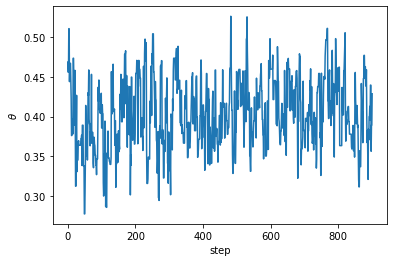

In [5]:
burnin_idx = 100

chain = chain[burnin_idx:]

plt.plot(chain)
plt.ylabel(r'$\theta$')
plt.xlabel('step');

Now we can bin the results to estimate what the posterior PDF looks like.

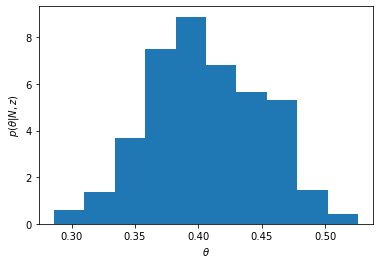

In [6]:
plt.hist(chain[burnin_idx:], density=True)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|N, z)$');

Since this is easy enough to evaluate the posterior over a grid of $\theta$ values, lets see how well our sampler did.

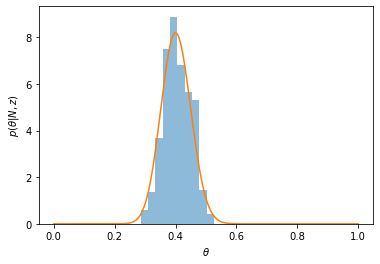

In [7]:
plt.hist(chain[burnin_idx:], density=True, alpha=0.5)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|N, z)$')

thetas = np.linspace(0, 1, 200)
plt.plot(thetas, posterior(thetas, N, z));

# Now in PyMC

In [3]:
import pymc3 as pm

The Bernoulli distribution expects data in the form of trials, e.g. $y=\{0, 1, 1, 0, 1, \ldots\}$, so we'll need to recast our data (e.g., $z, N$) into that form.  The order of arrival of heads and tails doesn't matter, so we'll just combine arrays of $1$'s and $0$'s of the proper lengths.

In [9]:
Y = np.concatenate([np.ones(z), np.zeros(N-z)])

In [10]:
flip_model = pm.Model()

with flip_model:
    # Priors for unknown model parameters
    theta = pm.Beta('theta', alpha=a, beta=b)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=theta, observed=Y)

Now lets take the same number of steps that we did with the homemade MCMC.

In [2]:
with flip_model:
    # draw posterior samples
    trace = pm.sample(nsteps)

NameError: name 'flip_model' is not defined

In [1]:
pm.traceplot(trace);

NameError: name 'pm' is not defined

# Why MCMC?

MCMC allows us to avoid wasting lots of computational resources evaluating the posterior in regions of low probability.  This is particularly importand when working in higher dimensions, or when the posterior is highly peaked with respect to the prior distribution.

Let's look at an example of the latter.  Let's say we've flipped a coin 100000000 times and seen 40000000 heads.  Let's try to look at the posterior over our usual grid.

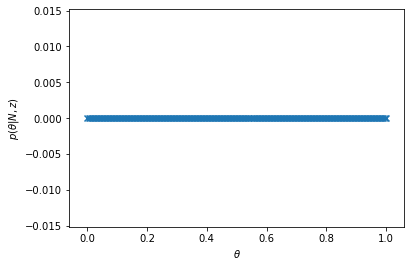

In [13]:
N = 100000000
z = 40000000

thetas = np.linspace(0, 1, 200)
plt.scatter(thetas, posterior(thetas, N, z), marker='x')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|N, z)$');

Our grid is not dense enough to see the peak at all.

Enhance.

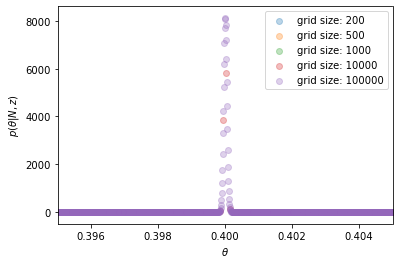

In [14]:
for ngrid in [200, 500, 1000, 10000, 100000]:
    thetas = np.linspace(0, 1, ngrid)
    plt.scatter(thetas, posterior(thetas, N, z), label='grid size: {}'.format(ngrid), alpha=0.3)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|N, z)$')
plt.legend()
plt.xlim(.395, .405);

Only once we've evaluated the posterior at $\sim10000$ points to we finally start getting a good estimate of the posterior distribution.

With MCMC, the chain will quickly move to the region of non-zero probability and draw samples from it.

Instead of using the Bernoulli distribtion in PyMC3, which expects a sequence of outcomes, we'll use the [binomial](https://docs.pymc.io/api/distributions/discrete.html#pymc3.distributions.discrete.Binomial) distibution.  This function allows us to specify $N$ and $z$ directly, which will be much faster for this many trials.

In [15]:
flip_model = pm.Model()

with flip_model:
    # Priors for unknown model parameters
    theta = pm.Beta('theta', alpha=a, beta=b)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Binomial('Y_obs', n=N, p=theta, observed=z);

In [16]:
with flip_model:
    # draw posterior samples
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:02<00:00, 4867.67draws/s]
The acceptance probability does not match the target. It is 0.9006517483740647, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9829951561775946, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9784472629086717, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8871795888461331, but should be close to 0.8. Try to increase the number of tuning steps.


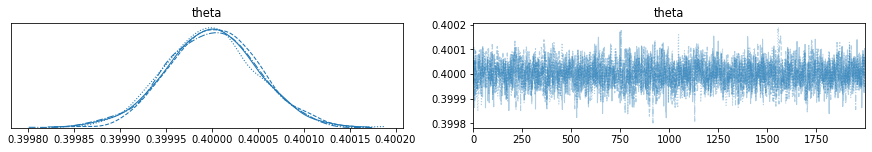

In [17]:
pm.traceplot(trace);

Thus, with only 5000 total evaluations of the posterior, we have a fairly good estimate of the posterior distribution on $\theta$.